In [1]:
#imports

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import linear_model
import statistics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import model_selection
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")

C:\Users\pietro.rinaldi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#get data
datasets = r'input'
output = r'output'

soc_dem = pd.read_excel(os.path.join(datasets,r'Task_Data_Scientist_Dataset.xlsx'),
                        dtype={0:'str'}, sheet_name=1).set_index('Client') 
prods_actbal = pd.read_excel(os.path.join(datasets,r'Task_Data_Scientist_Dataset.xlsx'),
                        dtype={0:'str'}, sheet_name=2).set_index('Client') 
inf_outf = pd.read_excel(os.path.join(datasets,r'Task_Data_Scientist_Dataset.xlsx'),
                        dtype={0:'str'}, sheet_name=3).set_index('Client')
sales_rev = pd.read_excel(os.path.join(datasets,r'Task_Data_Scientist_Dataset.xlsx'),
                        dtype={0:'str'}, sheet_name=4).set_index('Client') 

# Overview
The notebook will be split in 3 steps:

1) EDA 

2) Feature engineering and training & testing 

3) Prediction

In the first step, we will do a first analysis of the data, without going too much in detail to avoid the "data snooping" bias. We will build an analytical dataframe (DF), checking for missing values and get a first sense of the distribution. Then we will do a train / test split and dig deeper, for instance looking at correlations with target variables.

In the second step, we will work on feature engineering & model training to predict the target variables. Training will be done with cross validation, so as to reduce the need for an holdout set on top of the test set, since the number of data points is not enormous.
Models will be preliminary scored through cross-validation, tuned accordingly, and then we will assess the capacity of generalization of the best candidates on the test set.

Upon having chosen the best model(s), we will apply them in the 3rd step to predict the response variables, and based on this we will develop a proposal for a contact strategy.

## 1) EDA
### Let's start with getting an overview of the tables

We have a total of 1615 client IDs in the soc_dem table, which contains basic data.
The products & volumes table contains interesting "behavioral" data, but has a significant amount of missing values, which needs to be investigated. Most likely due to only some customers purchasing some products.

The inflow/outflow table contains credit card data for almost all the clients (18 missing vs sales & revenues table).

As expected, the sales & revenue table only contains data for 60% of the customers.

To be noted: CL & MF have relatively low counts, which means that in the prediction phase we will encounter the rare class problem.

Next step is understanding more the data at hand and seeing if any of the variables are highly correlated to the target variables.

Training & testing should take place on the data points containing scores, whereas prediction on the remaining 40%, provided the distributions for the variables on the second set is similar enough to the training set.

In [3]:
soc_dem.head()

,Sex,Age,Tenure
Client,,,
909,M,21,27
1217,M,38,165
850,F,49,44
1473,M,54,34
1038,M,29,106


In [4]:
soc_dem.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 909 to 1466
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Sex     1612 non-null   object
 1   Age     1615 non-null   int64 
 2   Tenure  1615 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 50.5+ KB


In [5]:
prods_actbal.head()

,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
Client,,,,,,,,,,,,
1,1,nan,nan,1.00,nan,nan,"1,333.80",nan,nan,0.00,nan,nan
2,1,1.00,nan,nan,nan,nan,110.77,"13,326.19",nan,nan,nan,nan
3,1,nan,1.00,nan,nan,nan,482.65,nan,107.25,nan,nan,nan
4,1,1.00,nan,nan,1.00,nan,"1,599.84",76.44,nan,nan,"1,110.38",nan
5,1,1.00,nan,nan,nan,nan,"5,353.48","8,079.72",nan,nan,nan,nan


In [6]:
prods_actbal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 1 to 1615
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Count_CA    1615 non-null   int64  
 1   Count_SA    426 non-null    float64
 2   Count_MF    306 non-null    float64
 3   Count_OVD   419 non-null    float64
 4   Count_CC    170 non-null    float64
 5   Count_CL    135 non-null    float64
 6   ActBal_CA   1615 non-null   float64
 7   ActBal_SA   426 non-null    float64
 8   ActBal_MF   306 non-null    float64
 9   ActBal_OVD  419 non-null    float64
 10  ActBal_CC   170 non-null    float64
 11  ActBal_CL   135 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 164.0+ KB


In [7]:
inf_outf.head()

,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
Client,,,,,,,,,,,,,,
1017,0.01,0.01,1,1,118.05,118.05,25.00,91.80,0.00,12,12,2,9,0
1456,364.77,364.75,4,3,774.98,774.98,14.29,497.44,258.61,28,28,1,20,5
545,"2,471.72","2,471.72",14,14,"2,190.26","2,190.26",303.57,179.08,"1,229.43",23,23,3,5,12
667,"1,127.79","1,127.79",4,4,"1,344.60","1,344.60",642.86,194.29,249.32,21,21,3,4,8
1381,571.62,571.62,3,3,57.07,57.07,10.71,46.36,0.00,6,6,1,5,0


In [8]:
inf_outf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1587 entries, 1017 to 773
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VolumeCred                    1587 non-null   float64
 1   VolumeCred_CA                 1587 non-null   float64
 2   TransactionsCred              1587 non-null   int64  
 3   TransactionsCred_CA           1587 non-null   int64  
 4   VolumeDeb                     1587 non-null   float64
 5   VolumeDeb_CA                  1587 non-null   float64
 6   VolumeDebCash_Card            1587 non-null   float64
 7   VolumeDebCashless_Card        1587 non-null   float64
 8   VolumeDeb_PaymentOrder        1587 non-null   float64
 9   TransactionsDeb               1587 non-null   int64  
 10  TransactionsDeb_CA            1587 non-null   int64  
 11  TransactionsDebCash_Card      1587 non-null   int64  
 12  TransactionsDebCashless_Card  1587 non-null   int64  
 13  Transa

In [9]:
sales_rev.head()

,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,
1094,0,1,0,0.00,5.14,0.00
1484,1,0,1,25.61,0.00,8.72
20,0,1,0,0.00,3.82,0.00
1193,0,0,0,0.00,0.00,0.00
142,0,0,0,0.00,0.00,0.00


In [10]:
sales_rev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 969 entries, 1094 to 1596
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sale_MF     969 non-null    int64  
 1   Sale_CC     969 non-null    int64  
 2   Sale_CL     969 non-null    int64  
 3   Revenue_MF  969 non-null    float64
 4   Revenue_CC  969 non-null    float64
 5   Revenue_CL  969 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 53.0+ KB


In [11]:
#merge dataframes

merge = soc_dem.merge(prods_actbal, left_index=True, right_index=True, how='left')
merge = merge.merge(inf_outf, left_index=True, right_index=True, how='left')
full = merge.merge(sales_rev, left_index=True, right_index=True, how='left')

#df with response variables
response = merge.merge(sales_rev, left_index=True, right_index=True, how='right')

In [12]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 909 to 1466
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           1612 non-null   object 
 1   Age                           1615 non-null   int64  
 2   Tenure                        1615 non-null   int64  
 3   Count_CA                      1615 non-null   int64  
 4   Count_SA                      426 non-null    float64
 5   Count_MF                      306 non-null    float64
 6   Count_OVD                     419 non-null    float64
 7   Count_CC                      170 non-null    float64
 8   Count_CL                      135 non-null    float64
 9   ActBal_CA                     1615 non-null   float64
 10  ActBal_SA                     426 non-null    float64
 11  ActBal_MF                     306 non-null    float64
 12  ActBal_OVD                    419 non-null    float64
 13  ActBal

#### Let's check some histograms & violin plots to see the variables distributions
Unsurprisingly, volume & transaction variables have a distribution which is approximately exponential (a case might be made for Weibull or lognormal, but given the high counts of 0s, exponential is probably the best approximation). We should keep this in mind when doing the feature engineering & modeling, as this might impact how we transform these variables.

Comparing credit vs debit, distributions are fairly similar in terms of mean, quartiles, and range. Total debit has slightly higher max, while the opposite is true if we consider CA.
In debit, CA & payment order are much higher than card transactions. For the purpose of this analysis, "cash card" payments are considered like withdrawals at an ATM with your card, while "cashless card" like paying at a store with your card. This seems to be consistent with cashless transactions being smaller and more frequent on average, and cash card transactions being bigger - given fixed withdrawal fees, it would be sensible for people to withdraw larger sums of money in fewer instances.
Outliers are present, looking at the maximum for most ActBal / Credit / Debit variables.

Credit transactions are fewer than debit. This could be explained, for instance, considering that most people get their salary as 1 monthly payment, whereas most monthly expenses are much smaller than one's salary.

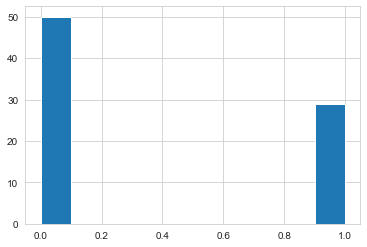

In [13]:
full[full['Count_CL'].isnull() == False]['Sale_CL'].hist()

In [14]:
full[full['Sale_CL'] == 0]['Count_CL'].value_counts()

1.00    46
2.00     4
Name: Count_CL, dtype: int64

In [15]:
full['Count_CL'].value_counts()

1.00    115
2.00     17
3.00      2
5.00      1
Name: Count_CL, dtype: int64

In [16]:
full['Count_CA'].value_counts()

1    1515
2      77
3      19
4       4
Name: Count_CA, dtype: int64

In [17]:
full[full['Count_MF'] > 0]['Count_MF'].count()

306

In [18]:
full['Sale_MF'].value_counts()

0.00    776
1.00    193
Name: Sale_MF, dtype: int64

In [19]:
full[['Tenure', 'Age']].describe()

,Tenure,Age
count,"1,615.00","1,615.00"
mean,101.34,42.85
std,64.92,18.55
min,0.00,0.00
25%,44.00,29.00
50%,97.00,41.00
75%,151.00,57.00
max,273.00,97.00


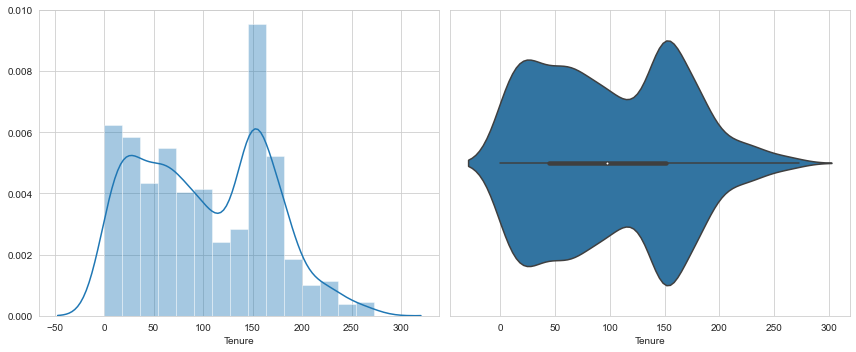

In [20]:
#looking at tenure, even customers in the lowest quartile tend to be with the bank for multiple years
#distribution is not really normal, but is not as extremely skewed as for transactions & volumes
#would be interesting also to compare activity during the tenure longitudinally, but not possible with available data

f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full['Tenure'], ax=axes[0])
sns.violinplot(full['Tenure'], ax=axes[1])
f.tight_layout()

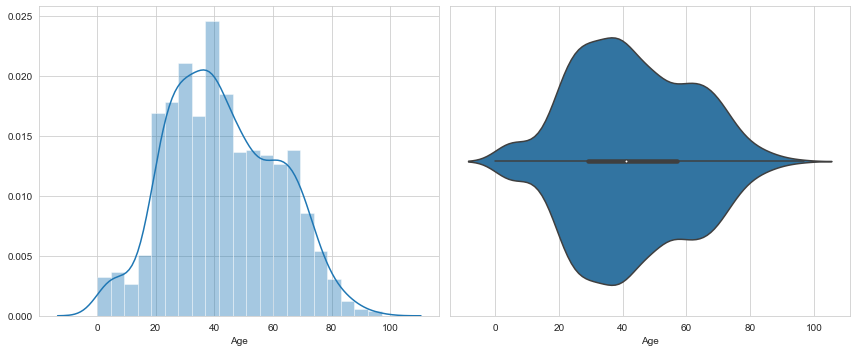

In [21]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full['Age'], ax=axes[0])
sns.violinplot(full['Age'], ax=axes[1])
f.tight_layout()

M   0.53
F   0.47
Name: Sex, dtype: float64


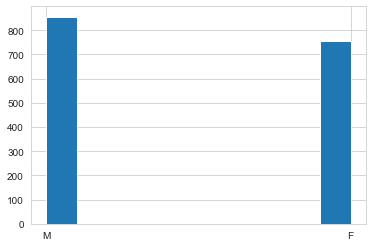

In [22]:
#males are more than females, which is somewhat surprising
#this variable will have to be dummified

full['Sex'].hist()
print(full['Sex'].value_counts() / full.shape[0])

In [23]:
#the values at the max for the variables would not suggest that they're clipped, meaning that the max is the "true max"

full[['VolumeCred', 'VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
     'VolumeDeb_PaymentOrder']].describe()

,VolumeCred,VolumeCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder
count,"1,587.00","1,587.00","1,587.00","1,587.00","1,587.00","1,587.00","1,587.00"
mean,"1,823.56","1,506.33","1,697.22","1,460.20",257.94,150.85,715.97
std,"5,864.79","4,661.54","5,183.79","4,281.37",757.73,311.94,"3,215.11"
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,252.92,214.29,226.21,211.85,0.00,0.00,0.00
50%,655.87,620.86,654.62,632.15,71.43,20.14,175.43
75%,"1,426.03","1,304.76","1,418.21","1,329.01",353.37,175.89,507.61
max,"107,703.80","98,717.68","119,906.50","73,477.93","23,571.43","3,637.62","72,278.78"


In [24]:
full[['TransactionsCred', 'TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 
      'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']].describe()

,TransactionsCred,TransactionsCred_CA,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,"1,587.00","1,587.00","1,587.00","1,587.00","1,587.00","1,587.00","1,587.00"
mean,5.54,4.27,16.01,13.60,1.99,5.24,4.60
std,6.36,4.94,16.24,12.98,2.71,8.39,5.21
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,2.00,4.00,4.00,0.00,0.00,0.00
50%,3.00,3.00,11.00,10.00,1.00,1.00,3.00
75%,6.00,4.00,22.00,19.00,3.00,7.00,7.00
max,63.00,48.00,102.00,83.00,25.00,60.00,34.00


In [25]:
full[['ActBal_CA', 'ActBal_SA', 'ActBal_MF','ActBal_OVD', 'ActBal_CC', 'ActBal_CL']].describe()

,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
count,"1,615.00",426.00,306.00,419.00,170.00,135.00
mean,"2,438.60","15,201.52","20,517.53",126.45,351.30,"4,237.64"
std,"7,072.78","32,365.18","78,046.99",290.57,486.68,"4,167.13"
min,0.00,0.00,0.00,0.00,-15.48,0.00
25%,61.56,728.14,0.00,0.00,1.24,"1,020.16"
50%,462.22,"4,413.50","1,700.94",0.00,153.01,"3,141.90"
75%,"2,174.86","14,622.67","11,169.18",93.11,545.01,"5,851.66"
max,"171,575.89","389,883.83","761,235.50","2,055.33","3,522.23","20,749.29"


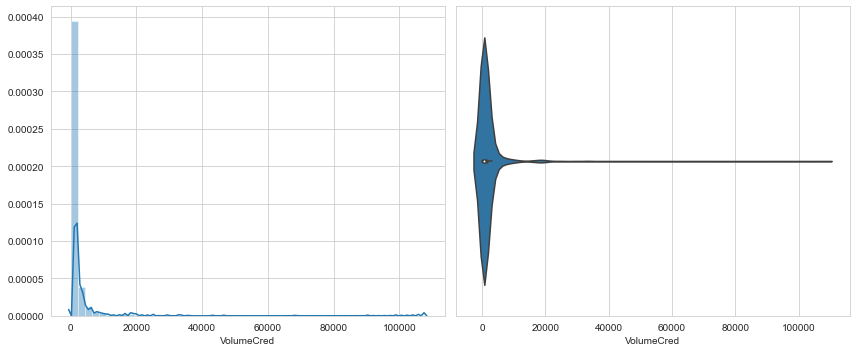

In [26]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['VolumeCred'].isnull()==False]['VolumeCred'], ax=axes[0])
sns.violinplot(full[full['VolumeCred'].isnull()==False]['VolumeCred'], ax=axes[1])
f.tight_layout()

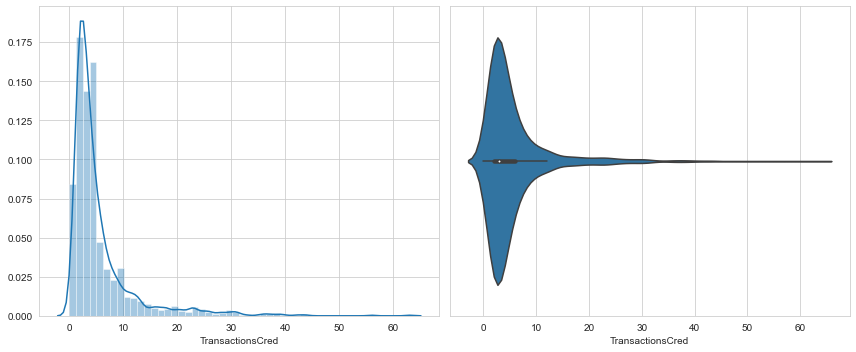

In [28]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['TransactionsCred'].isnull()==False]['TransactionsCred'], ax=axes[0])
sns.violinplot(full[full['TransactionsCred'].isnull()==False]['TransactionsCred'], ax=axes[1])
f.tight_layout()

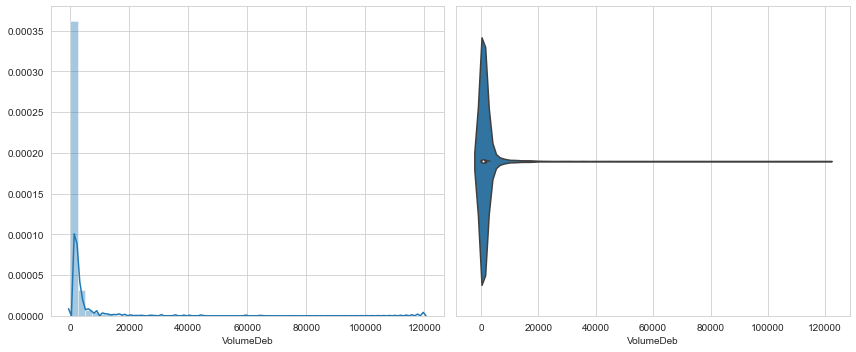

In [30]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['VolumeDeb'].isnull()==False]['VolumeDeb'], ax=axes[0])
sns.violinplot(full[full['VolumeDeb'].isnull()==False]['VolumeDeb'], ax=axes[1])
f.tight_layout()

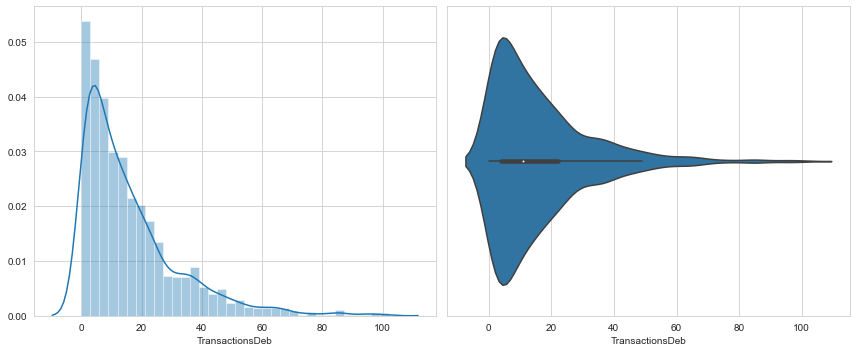

In [33]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['TransactionsDeb'].isnull()==False]['TransactionsDeb'], ax=axes[0])
sns.violinplot(full[full['TransactionsDeb'].isnull()==False]['TransactionsDeb'], ax=axes[1])
f.tight_layout()

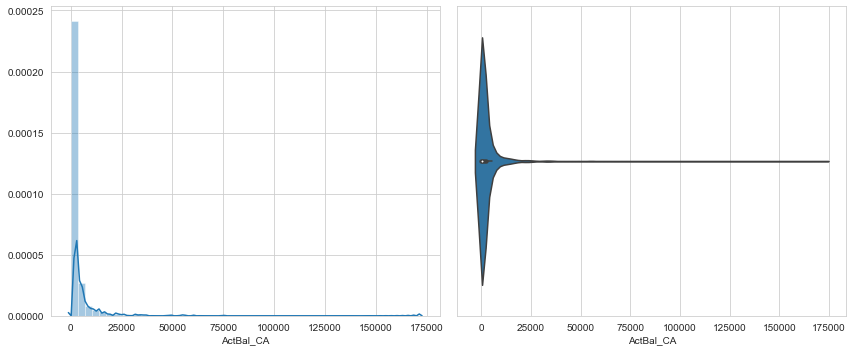

In [38]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['ActBal_CA'].isnull()==False]['ActBal_CA'], ax=axes[0])
sns.violinplot(full[full['ActBal_CA'].isnull()==False]['ActBal_CA'], ax=axes[1])
f.tight_layout()

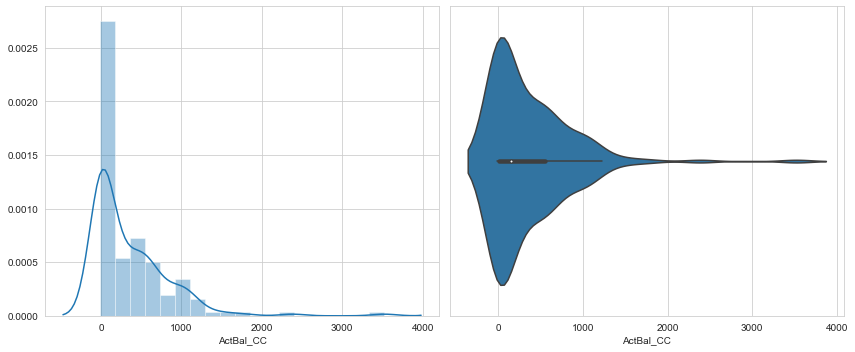

In [39]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['ActBal_CC'].isnull()==False]['ActBal_CC'], ax=axes[0])
sns.violinplot(full[full['ActBal_CC'].isnull()==False]['ActBal_CC'], ax=axes[1])
f.tight_layout()

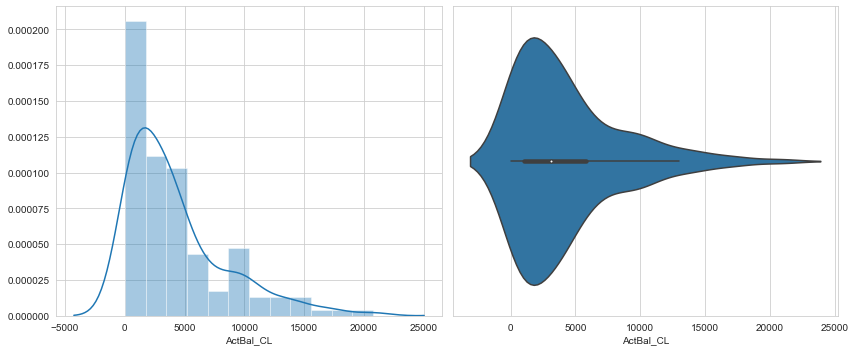

In [40]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['ActBal_CL'].isnull()==False]['ActBal_CL'], ax=axes[0])
sns.violinplot(full[full['ActBal_CL'].isnull()==False]['ActBal_CL'], ax=axes[1])
f.tight_layout()

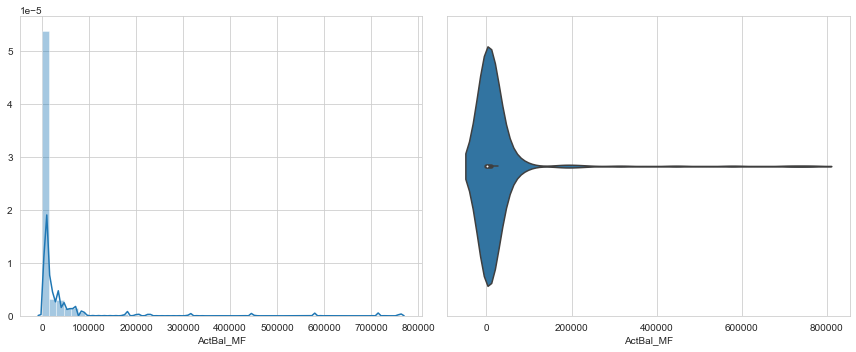

In [41]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(full[full['ActBal_MF'].isnull()==False]['ActBal_MF'], ax=axes[0])
sns.violinplot(full[full['ActBal_MF'].isnull()==False]['ActBal_MF'], ax=axes[1])
f.tight_layout()

## Train / Test split

Before diving deeper, it's a good idea to split the data in a train & test set to avoid the data snooping bias

Looking at outliers, some variables (like ActBal_MF or ActBal_SA) exhibit a maximum value significantly higher than others, but these do not seem like broken data points, so removing them would exclude valid information. Using robust scaling methods is likely to produce better results.
Surprisingly, standard scaler produces better output than robust scaler (Which should be able to better handle outliers) and PowerTransformer (which should be more capable to handle the distribution the data is in).

In [44]:
response.columns

Index(['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [45]:
#response = response[response['VolumeCred']<response['VolumeCred'].quantile(0.99)]
#response = response[response['TransactionsDeb']<response['TransactionsDeb'].quantile(0.99)]
#response = response[response['TransactionsCred']<response['TransactionsCred'].quantile(0.99)]

#response = response[((response['ActBal_MF']<response['ActBal_MF'].quantile(0.99)) | (response['ActBal_MF'].isnull()==True))]
#response = response.dropna(subset=['VolumeDeb', 'Sex'])

X = response.iloc[:,:-6]
y = response.iloc[:,-6:]

#we're going for random sampling, but stratified sampling on some variable (like CA balance) might be considered, 
#depending on available time.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#we will carry on with the EDA on this df, to avoid biasing ourselves with test set information

train_full = X_train.merge(y_train, left_index=True, right_index=True)

In [46]:
response.info()

<class 'pandas.core.frame.DataFrame'>
Index: 969 entries, 1094 to 1596
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           967 non-null    object 
 1   Age                           969 non-null    int64  
 2   Tenure                        969 non-null    int64  
 3   Count_CA                      969 non-null    int64  
 4   Count_SA                      265 non-null    float64
 5   Count_MF                      184 non-null    float64
 6   Count_OVD                     251 non-null    float64
 7   Count_CC                      110 non-null    float64
 8   Count_CL                      79 non-null     float64
 9   ActBal_CA                     969 non-null    float64
 10  ActBal_SA                     265 non-null    float64
 11  ActBal_MF                     184 non-null    float64
 12  ActBal_OVD                    251 non-null    float64
 13  ActBal

In [47]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 1334 to 412
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           773 non-null    object 
 1   Age                           775 non-null    int64  
 2   Tenure                        775 non-null    int64  
 3   Count_CA                      775 non-null    int64  
 4   Count_SA                      201 non-null    float64
 5   Count_MF                      141 non-null    float64
 6   Count_OVD                     200 non-null    float64
 7   Count_CC                      88 non-null     float64
 8   Count_CL                      62 non-null     float64
 9   ActBal_CA                     775 non-null    float64
 10  ActBal_SA                     201 non-null    float64
 11  ActBal_MF                     141 non-null    float64
 12  ActBal_OVD                    200 non-null    float64
 13  ActBal_

In [48]:
#it looks like that customers have multiple MF & CL, but only one CC

train_full[['Count_MF', 'Count_CC','Count_CL']].describe()

,Count_MF,Count_CC,Count_CL
count,141.00,88.00,62.00
mean,5.55,1.00,1.08
std,10.23,0.00,0.27
min,1.00,1.00,1.00
25%,1.00,1.00,1.00
50%,2.00,1.00,1.00
75%,5.00,1.00,1.00
max,79.00,1.00,2.00


In [49]:
#sales response variables are binary as expected

train_full[['Sale_MF', 'Sale_CC','Sale_CL']].describe()

,Sale_MF,Sale_CC,Sale_CL
count,775.00,775.00,775.00
mean,0.20,0.25,0.31
std,0.40,0.43,0.46
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,1.00
max,1.00,1.00,1.00


In [50]:
#overall, it would seem CCs & CL are more profitable than MF. Let's dig a bit deeper

train_full[['Revenue_MF', 'Revenue_CC','Revenue_CL']].describe()

,Revenue_MF,Revenue_CC,Revenue_CL
count,775.00,775.00,775.00
mean,1.66,2.56,3.78
std,6.82,16.71,8.03
min,0.00,0.00,0.00
25%,0.00,0.00,0.00
50%,0.00,0.00,0.00
75%,0.00,0.00,5.29
max,83.04,407.96,133.28


In [51]:
train_full[train_full['Sale_CC'] > 0].count()[0]

193

In [52]:
rev_mf = train_full['Revenue_MF'].sum().round(2)
rev_cc = train_full['Revenue_CC'].sum().round(2)
rev_cl = train_full['Revenue_CL'].sum().round(2)

count_mf = train_full[train_full['Sale_MF'] > 0].count()[0]
count_cc = train_full[train_full['Sale_CC'] > 0].count()[0]
count_cl = train_full[train_full['Sale_CL'] > 0].count()[0]


#let's compute mean & median for those customers that purchase the relevant financial instruments
median_mf = round(statistics.median(train_full[train_full['Revenue_MF'] > 0]['Revenue_MF']), 2)
median_cc = round(statistics.median(train_full[train_full['Revenue_CC'] > 0]['Revenue_CC']), 2)
median_cl = round(statistics.median(train_full[train_full['Revenue_CL'] > 0]['Revenue_CL']), 2)
mean_mf = round(statistics.mean(train_full[train_full['Revenue_MF'] > 0]['Revenue_MF']), 2)
mean_cc = round(statistics.mean(train_full[train_full['Revenue_CC'] > 0]['Revenue_CC']), 2)
mean_cl = round(statistics.mean(train_full[train_full['Revenue_CL'] > 0]['Revenue_CL']), 2)

print('For MF, total revenues are {}, with a median of {} and mean of {}. Positive class count {}'.format(rev_mf, median_mf, mean_mf, count_mf))
print('For CC, total revenues are {}, with a median of {} and mean of {}. Positive class count {}'.format(rev_cc, median_cc, mean_cc, count_cc))
print('For CL, total revenues are {}, with a median of {} and mean of {}. Positive class count {}'.format(rev_cl, median_cl, mean_cl, count_cl))
print('CL and CC seem indeed to generate more revenues, especially CL. In the absence of further constraints, they should be prioritized.')
print('Further constraints could include probability of default (absent in MF), sample size, cost of contacting / making an offer if different')

For MF, total revenues are 1286.75, with a median of 3.2 and mean of 8.2. Positive class count 157
For CC, total revenues are 1986.9, with a median of 4.46 and mean of 10.29. Positive class count 193
For CL, total revenues are 2928.74, with a median of 10.95 and mean of 12.2. Positive class count 239
CL and CC seem indeed to generate more revenues, especially CL. In the absence of further constraints, they should be prioritized.
Further constraints could include probability of default (absent in MF), sample size, cost of contacting / making an offer if different


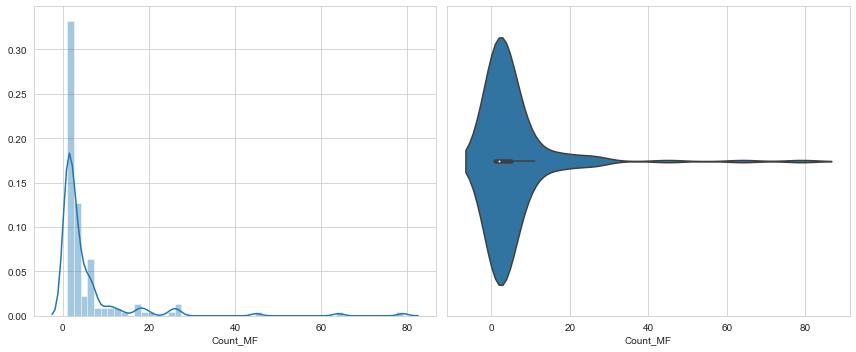

In [53]:
#as expected, this distribution is skewed to the right and also somewhat exponential
#most MF buyers tend to have few (<= 2) MFs, but some "serial investors" can have many
#could be interesting to target potential "serial investors", if they can be properly identified

f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(train_full[train_full['Count_MF'].isnull()==False]['Count_MF'], ax=axes[0])
sns.violinplot(train_full[train_full['Count_MF'].isnull()==False]['Count_MF'], ax=axes[1])
f.tight_layout()

C:\Users\pietro.rinaldi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\pietro.rinaldi\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


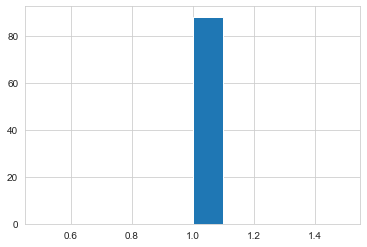

In [54]:
#only one CC per customer

plt.hist(train_full['Count_CC']);

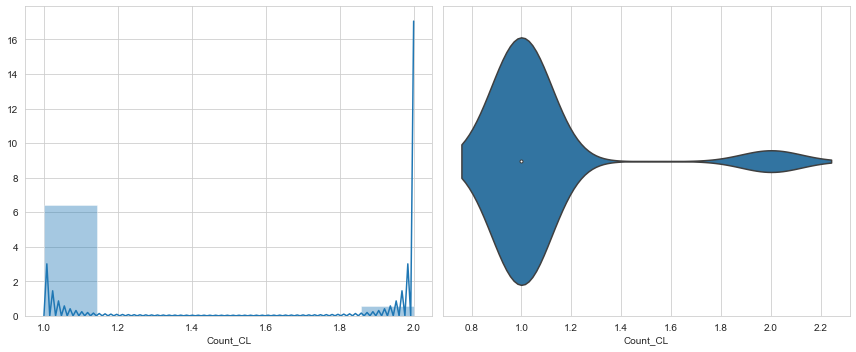

In [55]:
#most CL buyers tend to only have one, but a few take two
#marketing multiple loans to the same customer can be fairly risky, so it'd be unwise to go down this road without consulting a domain expert first

f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(train_full[train_full['Count_CL'].isnull()==False]['Count_CL'], ax=axes[0])
sns.violinplot(train_full[train_full['Count_CL'].isnull()==False]['Count_CL'], ax=axes[1])
f.tight_layout()

### Data count

We have significant amounts of missing values:
- MF, CC, and CL counts are much lower than the sum of the response variables, same applies to the ActBal table since the counts refer to "live" product, we'll assume that customers with a 1 for the response variable and a null in the count deactivated it
    - e.g., deactivated a credit card, fully repaid a loan, or sold a MF
    - with this assumption, the nulls in the "Count_XX" variables can be filled with 0s, same applies to the "ActBal_XX" fields
- other null values are in Sex and in the Inflow/Outflow table, impacting approximately 10 data points
    - here the choice will be between inputing, deleting, or choosing an algorithm capable of handling missing values

In [56]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 1334 to 412
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           773 non-null    object 
 1   Age                           775 non-null    int64  
 2   Tenure                        775 non-null    int64  
 3   Count_CA                      775 non-null    int64  
 4   Count_SA                      201 non-null    float64
 5   Count_MF                      141 non-null    float64
 6   Count_OVD                     200 non-null    float64
 7   Count_CC                      88 non-null     float64
 8   Count_CL                      62 non-null     float64
 9   ActBal_CA                     775 non-null    float64
 10  ActBal_SA                     201 non-null    float64
 11  ActBal_MF                     141 non-null    float64
 12  ActBal_OVD                    200 non-null    float64
 13  ActBal_

In [57]:
full['Sale_CC'].sum()

242.0

In [58]:
full[(full['Count_CC'].isnull() == True) & (full['Sale_CC'] > 0)]

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
850,F,49,44,1,nan,nan,nan,nan,nan,43.52,...,6.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.89,0.00
739,M,69,55,1,1.00,8.00,1.00,nan,1.00,"5,519.31",...,5.00,0.00,3.00,0.00,0.00,1.00,1.00,0.00,2.14,7.79
137,F,63,168,3,nan,1.00,nan,nan,nan,185.72,...,11.00,1.00,6.00,3.00,0.00,1.00,0.00,0.00,9.39,0.00
1160,M,19,260,1,nan,nan,1.00,nan,1.00,"2,723.98",...,26.00,3.00,9.00,7.00,0.00,1.00,1.00,0.00,0.86,17.99
729,M,17,85,1,1.00,1.00,1.00,nan,nan,"2,082.31",...,14.00,0.00,0.00,11.00,0.00,1.00,1.00,0.00,3.50,28.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1500,F,33,15,1,nan,nan,1.00,nan,nan,90.45,...,0.00,0.00,0.00,0.00,1.00,1.00,1.00,21.03,2.35,6.57
809,M,30,157,1,nan,nan,nan,nan,1.00,16.62,...,28.00,3.00,20.00,2.00,0.00,1.00,1.00,0.00,6.96,8.26
833,M,36,150,1,nan,nan,nan,nan,nan,"3,017.64",...,nan,nan,nan,nan,0.00,1.00,0.00,0.00,5.00,0.00


In [59]:
full['Sale_CC'].sum()

242.0

### Correlations

Let's take a look at the correlation heatmap to see the strongest relationships between the variables. This might help us identify good candidates for predictor variables.

MF: pos correlation with debit cashless & debit/credit transactions, negative with CL & SA (143 positive)

CC: fairly strong pos correlation with ActBal CA & SA, less with volumes deb / volumes deb CA. Negative correlation with Count CL & MF (195 positive)

CL: fairly strong pos correlation with tenure & OVD, negative with age, ActBal CC & SA, Sale MF (235 positive)

In the training set, 55 CC customers have a CL (28% of CC customers). CL is the most sold product. 36 have a MF (25%)
32 CC customers, or 22%, have a MF.


Preliminary conclusions: 
- MF customers tend to shy away from saving accounts and loans, and tend to perform more transactions
- CC customers tend to have higher active balances in their saving accounts and current accounts
- CL customers tend to have higher tenure with the bank, are more likely to have an overdraft, are younger and have a lower CC balance (if they have a CC)

In [60]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 775 entries, 1334 to 412
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           773 non-null    object 
 1   Age                           775 non-null    int64  
 2   Tenure                        775 non-null    int64  
 3   Count_CA                      775 non-null    int64  
 4   Count_SA                      201 non-null    float64
 5   Count_MF                      141 non-null    float64
 6   Count_OVD                     200 non-null    float64
 7   Count_CC                      88 non-null     float64
 8   Count_CL                      62 non-null     float64
 9   ActBal_CA                     775 non-null    float64
 10  ActBal_SA                     201 non-null    float64
 11  ActBal_MF                     141 non-null    float64
 12  ActBal_OVD                    200 non-null    float64
 13  ActBal_

In [61]:
train_full.columns

Index(['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [62]:
corr_matrix = train_full.corr()

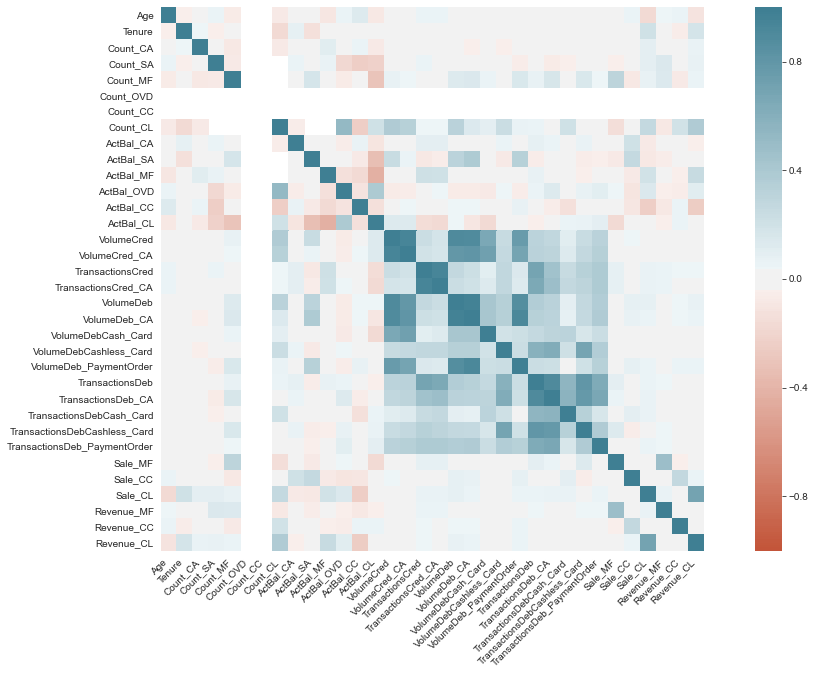

In [63]:
from matplotlib import rcParams

corr = corr_matrix
fig, ax = plt.subplots(figsize=(18,10))    
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [64]:
#let's create a pipeline

import scipy.stats

#feature engineering
X_train_prepared = X_train.copy()
print(X_train_prepared.shape)

#we have 1 NA in the training set, and imputing with a split close to 50/50 is a bit random, so we can remove it
X_train_prepared = X_train_prepared.dropna(subset=['Sex'])

#we can assume customers with a null count/balance in either product do not have it, and so count/balance is 0
na_cols_fill0 = ['Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL',
                'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL',]


#fill with median (worked better than mean)
fill_median = ['VolumeCred', 'VolumeCred_CA',
               'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
               'VolumeDebCash_Card', 'VolumeDebCashless_Card',
               'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
               'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']

#creating new features - further features did more harm than good
X_train_prepared['balance_tot'] = X_train_prepared['VolumeCred'] - X_train_prepared['VolumeDeb'] 
X_train_prepared['balance_CA'] = X_train_prepared['VolumeCred_CA'] - X_train_prepared['VolumeDeb_CA'] 

cat_c = ['Sex']

na_imputer = Pipeline([
    ('naimputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])

sex_imputer = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse=False)),
])

median_imputer = Pipeline([
    ('medianimputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

scaler_rest = Pipeline([
    ('scaler', StandardScaler()),
])

rest = list(set(X_train_prepared.columns) - set(na_cols_fill0) - set(fill_median) - set(cat_c))

full_pipeline = ColumnTransformer([
    ('nas', na_imputer, na_cols_fill0),
    ('sexcol', sex_imputer, cat_c), 
    ('medimp', median_imputer, fill_median),
    ('rest', scaler_rest, rest),
],     remainder='drop')

X_train_prepared = pd.DataFrame(full_pipeline.fit_transform(X_train_prepared), columns=X_train_prepared.columns, index=X_train_prepared.index)

#winsorizing outliers (0.005 proved to be optimal threshold)
quant_cols = list(X_train_prepared.columns[3:])

X_train_prepared[quant_cols] = scipy.stats.mstats.winsorize(a=X_train_prepared[quant_cols], limits=0.005, inplace=True)
print(X_train_prepared.shape)

#repeat steps for test
X_test_prepared = X_test.copy()
print(X_test_prepared.shape)
X_test_prepared = X_test_prepared.dropna(subset=['Sex'])
X_test_prepared['balance_tot'] = X_test_prepared['VolumeCred'] - X_test_prepared['VolumeDeb'] 
X_test_prepared['balance_CA'] = X_test_prepared['VolumeCred_CA'] - X_test_prepared['VolumeDeb_CA'] 
X_test_prepared = pd.DataFrame(full_pipeline.transform(X_test_prepared), columns=X_test_prepared.columns, index=X_test_prepared.index)
X_test_prepared[quant_cols] = scipy.stats.mstats.winsorize(a=X_test_prepared[quant_cols], limits=0.005, inplace=True)

print(X_test_prepared.shape)

#only keep rows in y that are also in x
y_train = y_train[y_train.index.isin(X_train_prepared.index)]
y_test = y_test[y_test.index.isin(X_test_prepared.index)]

print(y_train.shape)
print(y_test.shape)

(775, 29)
(773, 31)
(194, 29)
(194, 31)
(773, 6)
(194, 6)


In [65]:
X_train_prepared['VolumeDeb'].sum()

-19.720992075609022

In [66]:
X_train['VolumeDeb'].sum()

1335077.8675

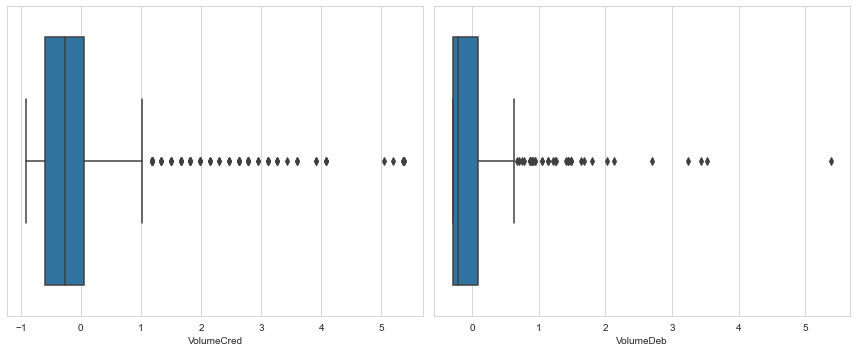

In [67]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(X_train_prepared[X_train_prepared['VolumeCred'].isnull()==False]['VolumeCred'], ax=axes[0])
sns.boxplot(X_train_prepared[X_train_prepared['VolumeDeb'].isnull()==False]['VolumeDeb'], ax=axes[1])
f.tight_layout()

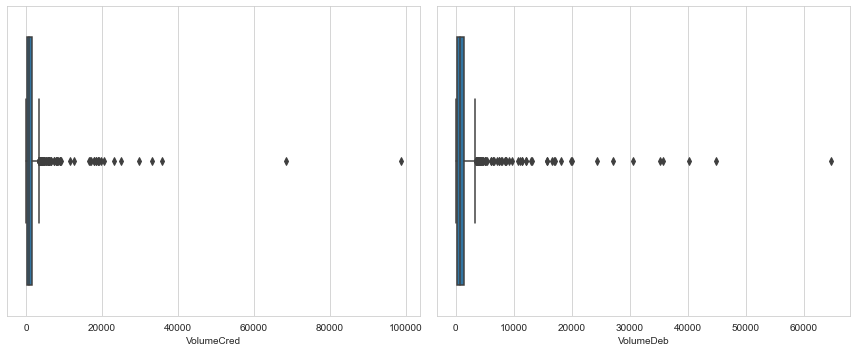

In [68]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.boxplot(X_train[X_train['VolumeCred'].isnull()==False]['VolumeCred'], ax=axes[0])
sns.boxplot(X_train[X_train['VolumeDeb'].isnull()==False]['VolumeDeb'], ax=axes[1])
f.tight_layout()

In [69]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 1334 to 412
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sale_MF     773 non-null    int64  
 1   Sale_CC     773 non-null    int64  
 2   Sale_CL     773 non-null    int64  
 3   Revenue_MF  773 non-null    float64
 4   Revenue_CC  773 non-null    float64
 5   Revenue_CL  773 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 42.3+ KB


In [70]:
X_train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 1334 to 412
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Sex                           773 non-null    float64
 1   Age                           773 non-null    float64
 2   Tenure                        773 non-null    float64
 3   Count_CA                      773 non-null    float64
 4   Count_SA                      773 non-null    float64
 5   Count_MF                      773 non-null    float64
 6   Count_OVD                     773 non-null    float64
 7   Count_CC                      773 non-null    float64
 8   Count_CL                      773 non-null    float64
 9   ActBal_CA                     773 non-null    float64
 10  ActBal_SA                     773 non-null    float64
 11  ActBal_MF                     773 non-null    float64
 12  ActBal_OVD                    773 non-null    float64
 13  ActBal_

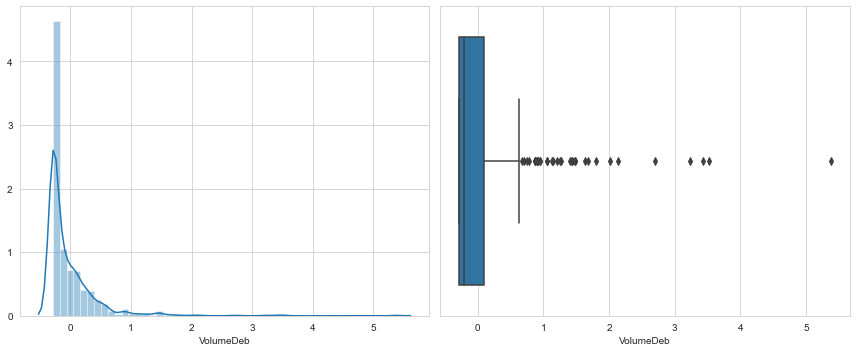

In [71]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(X_train_prepared['VolumeDeb'], ax=axes[0])
sns.boxplot(X_train_prepared['VolumeDeb'], ax=axes[1])
f.tight_layout()

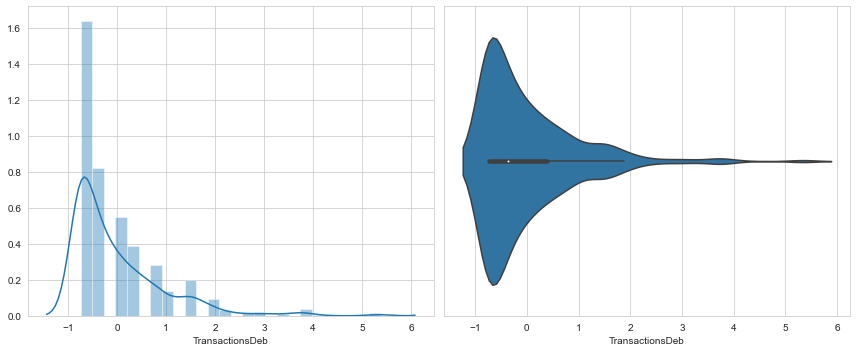

In [72]:
f, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(X_train_prepared['TransactionsDeb'], ax=axes[0])
sns.violinplot(X_train_prepared['TransactionsDeb'], ax=axes[1])
f.tight_layout()

In [73]:
#weighting the imbalanced classes

outcome_mf = 'Sale_MF'

default_wt = 1 / np.mean(y_train['Sale_MF'])
wt_mf = [default_wt if outcome_mf == 1 else 1 for outcome_mf in y_train['Sale_MF']]
print(sum(wt_mf)/len(wt_mf))

outcome_cc = 'Sale_CC'

default_wt = 1 / np.mean(y_train['Sale_CC'])
wt_cc = [default_wt if outcome_cc == 1 else 1 for outcome_cc in y_train['Sale_CC']]
print(sum(wt_cc)/len(wt_cc))

outcome_cl = 'Sale_CL'

default_wt = 1 / np.mean(y_train['Sale_CL'])
wt_cl = [default_wt if outcome_cl == 1 else 1 for outcome_cl in y_train['Sale_CL']]
print(sum(wt_cl)/len(wt_cl))

1.7968952134540706
1.7503234152651996
1.6908150064683083


In [74]:
#let's create a dataset per target variable
#we are keeping the counts because a potential customer might already have a MF/CC/CL

X_train_prepared_mf = X_train_prepared
y_train_mf = y_train[['Sale_MF']]

X_train_prepared_cc = X_train_prepared
y_train_cc = y_train[['Sale_CC']]

X_train_prepared_cl = X_train_prepared
y_train_cl = y_train[['Sale_CL']]


X_test_prepared_mf = X_test_prepared
y_test_mf = y_test[['Sale_MF']]
X_test_prepared_cc = X_test_prepared
y_test_cc = y_test[['Sale_CC']]
X_test_prepared_cl = X_test_prepared
y_test_cl = y_test[['Sale_CL']]

In [75]:
y_train_mf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 773 entries, 1334 to 412
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Sale_MF  773 non-null    int64
dtypes: int64(1)
memory usage: 12.1+ KB


In [76]:
%%time
#clf_mf = LogisticRegression(random_state=42, class_weight='balanced', solver='saga', max_iter=1000000, penalty='elasticnet', l1_ratio=0.4)
clf_mf = LogisticRegression(random_state=42, class_weight='balanced', solver='lbfgs', max_iter=100000, penalty='l2')
clf_mf.fit(X_train_prepared_mf, y_train_mf['Sale_MF'].values) 

y_pred_mf = sklearn.model_selection.cross_val_predict(clf_mf, X=X_train_prepared_mf, y=y_train_mf['Sale_MF'].values, cv=5)

print(classification_report(y_train_mf, y_pred_mf))
print(sklearn.metrics.roc_auc_score(y_train_mf, y_pred_mf))

y_pred_mf.sum() / len(y_pred_mf)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       616
           1       0.31      0.54      0.39       157

    accuracy                           0.66       773
   macro avg       0.58      0.61      0.58       773
weighted avg       0.74      0.66      0.69       773

0.6132951443460997
Wall time: 135 ms


0.35446313065976714

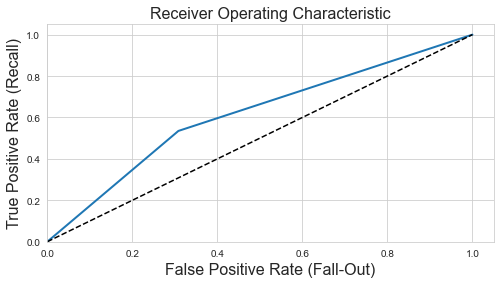

In [77]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_mf['Sale_MF'].values, y_pred_mf)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1.05, 0, 1.05])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            
    plt.title('Receiver Operating Characteristic', fontsize=16)

plt.figure(figsize=(8, 4))                         
plot_roc_curve(fpr, tpr)                       
plt.show()

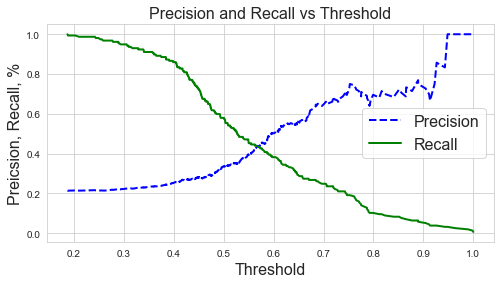

In [78]:
from sklearn.metrics import precision_recall_curve

y_scores = clf_mf.predict_proba(X_train_prepared_mf)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_mf['Sale_MF'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [79]:
y_pred_mf_tr = clf_mf.predict_proba(X_train_prepared_mf)
tresh = 0.8
pred_2 = []

for x in y_pred_mf_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_mf, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       616
           1       0.68      0.10      0.17       157

    accuracy                           0.81       773
   macro avg       0.75      0.54      0.53       773
weighted avg       0.78      0.81      0.74       773

22


In [80]:
%%time

#scale_pos_weight = total_negative_examples / total_positive_examples
wt_xgb_mf = len(y_train[y_train['Sale_MF'] == 0])/sum(y_train['Sale_MF'])

xgb_clf_mf = xgb.XGBClassifier(
    max_depth=10,
    learning_rate=0.00001,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=18,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=wt_xgb_mf,
    base_score=0.5,
    random_state=0,
    seed=42,
    missing=None
)

xgb_dmat = xgb.DMatrix(X_train_prepared_mf, label=y_train_mf)


xgb_clf_mf.fit(X_train_prepared_mf, y_train_mf['Sale_MF'].values)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_clf_mf.score(X_train_prepared_mf, y_train_mf)))

y_pred_mf = sklearn.model_selection.cross_val_predict(xgb_clf_mf, X=X_train_prepared_mf, y=y_train_mf['Sale_MF'].values, cv=10)

print(classification_report(y_train_mf, y_pred_mf))
print(sklearn.metrics.roc_auc_score(y_train_mf, y_pred_mf))

y_pred_mf.sum() / len(y_pred_mf)

Accuracy of XGB classifier on training set: 0.87
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       616
           1       0.31      0.35      0.33       157

    accuracy                           0.71       773
   macro avg       0.57      0.58      0.57       773
weighted avg       0.72      0.71      0.72       773

0.5769449499545041
Wall time: 4 s


0.2276843467011643

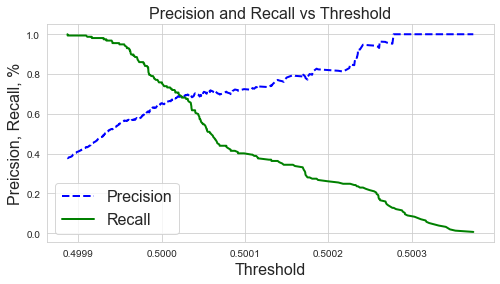

In [81]:
y_scores = xgb_clf_mf.predict_proba(X_train_prepared_mf)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_mf['Sale_MF'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [82]:
y_pred_mf_tr = xgb_clf_mf.predict_proba(X_train_prepared_mf)
tresh = 0.5002

pred_2 = []

for x in y_pred_mf_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_mf, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       616
           1       0.82      0.25      0.39       157

    accuracy                           0.84       773
   macro avg       0.83      0.62      0.65       773
weighted avg       0.83      0.84      0.80       773

49


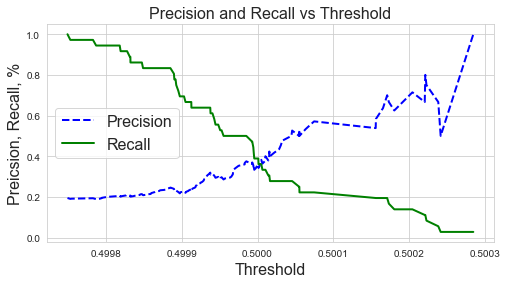

In [83]:
y_scores = xgb_clf_mf.predict_proba(X_test_prepared_mf)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_mf['Sale_MF'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [84]:
#unfortunately, we have a significant score loss in the test set
#regularizing more through hyperparameter tuning does not help reduce overfitting

y_pred_mf_tr = xgb_clf_mf.predict_proba(X_test_prepared_mf)
tresh = 0.50017

pred_2 = []

for x in y_pred_mf_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_test_mf, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       158
           1       0.70      0.19      0.30        36

    accuracy                           0.84       194
   macro avg       0.77      0.59      0.61       194
weighted avg       0.82      0.84      0.79       194

10


In [85]:
y_train

,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,
1334,0,0,0,0.00,0.00,0.00
692,0,1,1,0.00,4.29,13.13
1338,1,0,0,19.46,0.00,0.00
1328,0,0,0,0.00,0.00,0.00
268,0,0,0,0.00,0.00,0.00
...,...,...,...,...,...,...
1563,0,0,1,0.00,0.00,10.77
901,1,0,0,0.14,0.00,0.00
1330,0,1,0,0.00,4.36,0.00


In [86]:
#let's predict revenues now
xgb_reg_mf = xgb.XGBRegressor(
    max_depth=10,
    learning_rate=0.00001,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='reg:squarederror',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=18,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=wt_xgb_mf,
    base_score=0.5,
    random_state=0,
    seed=42,
    missing=None
)

xgb_dmat = xgb.DMatrix(X_train_prepared_mf, label=y_train['Revenue_MF'])


xgb_reg_mf.fit(X_train_prepared_mf, y_train_mf['Sale_MF'].values)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_reg_mf.score(X_train_prepared_mf, y_train['Revenue_MF'])))

y_pred_reg_mf = sklearn.model_selection.cross_val_predict(xgb_reg_mf, X=X_train_prepared_mf, y=y_train['Revenue_MF'].values, cv=10)

Accuracy of XGB classifier on training set: -0.03


In [87]:
X_test.shape[0]

194

In [88]:
full[full['Sale_MF'].isnull()==True].shape

(646, 35)

In [89]:
clf_cc = LogisticRegression(random_state=42, class_weight='balanced', solver='lbfgs', max_iter=10000)
clf_cc.fit(X_train_prepared_cc, y_train_cc['Sale_CC'].values) 

y_pred_cc = sklearn.model_selection.cross_val_predict(clf_cc, X=X_train_prepared_cc, y=y_train_cc['Sale_CC'].values, cv=5)

print(classification_report(y_train_cc, y_pred_cc))
print(sklearn.metrics.roc_auc_score(y_train_cc, y_pred_cc))

y_pred_cc.sum() / len(y_pred_cc)

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       580
           1       0.40      0.51      0.45       193

    accuracy                           0.68       773
   macro avg       0.61      0.63      0.61       773
weighted avg       0.71      0.68      0.70       773

0.6263042701447205


0.32341526520051744

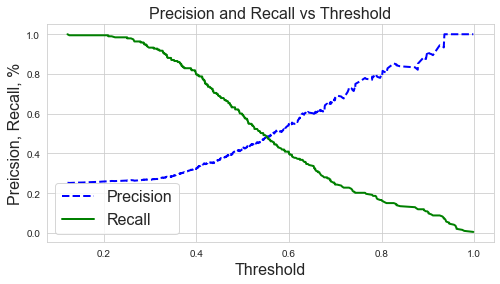

In [90]:
y_scores = clf_cc.predict_proba(X_train_prepared_cc)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_cc['Sale_CC'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [91]:
y_pred_cc_tr = clf_cc.predict_proba(X_train_prepared_cc)
tresh = 0.8
pred_2 = []

for x in y_pred_cc_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_cc, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.78      0.99      0.87       580
           1       0.79      0.16      0.27       193

    accuracy                           0.78       773
   macro avg       0.79      0.57      0.57       773
weighted avg       0.78      0.78      0.72       773

39


In [92]:
%%time

#scale_pos_weight = total_negative_examples / total_positive_examples
wt_xgb_cc = len(y_train[y_train['Sale_CC'] == 0])/sum(y_train['Sale_CC'])

xgb_clf_cc = xgb.XGBClassifier(
    max_depth=10,
    learning_rate=0.00001,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=18,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight=wt_xgb_cc,
    base_score=0.5,
    random_state=0,
    seed=42,
    missing=None
)

xgb_dmat = xgb.DMatrix(X_train_prepared_cc, label=y_train_cc)


xgb_clf_cc.fit(X_train_prepared_cc, y_train_cc['Sale_CC'].values)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_clf_cc.score(X_train_prepared_cc, y_train_cc)))

y_pred_cc = sklearn.model_selection.cross_val_predict(xgb_clf_cc, X=X_train_prepared_cc, y=y_train_cc['Sale_CC'].values, cv=5)

print(classification_report(y_train_cc, y_pred_cc))
print(sklearn.metrics.roc_auc_score(y_train_cc, y_pred_cc))

y_pred_cc.sum() / len(y_pred_cc)

Accuracy of XGB classifier on training set: 0.81
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       580
           1       0.44      0.30      0.35       193

    accuracy                           0.73       773
   macro avg       0.61      0.58      0.59       773
weighted avg       0.70      0.73      0.71       773

0.5838752903341075
Wall time: 2.37 s


0.16946959896507116

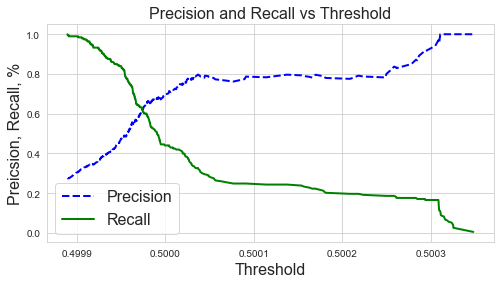

In [93]:
y_scores = xgb_clf_cc.predict_proba(X_train_prepared_cc)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_cc['Sale_CC'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [94]:
y_pred_cc_tr = xgb_clf_cc.predict_proba(X_train_prepared_cc)
tresh = 0.500305
pred_2 = []

for x in y_pred_cc_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_cc, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       580
           1       0.97      0.17      0.28       193

    accuracy                           0.79       773
   macro avg       0.88      0.58      0.58       773
weighted avg       0.83      0.79      0.73       773

33


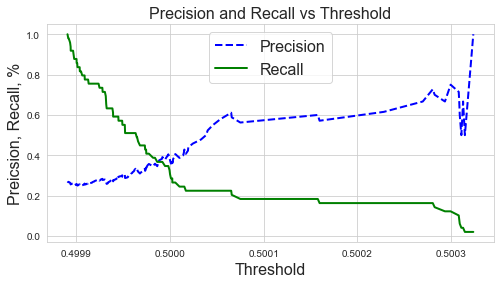

In [95]:
y_scores = xgb_clf_cc.predict_proba(X_test_prepared_cc)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_cc['Sale_CC'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [96]:
#also here tangible reduction in test scores
#regularizing more through hyperparameter tuning does not help reduce overfitting


y_pred_cc_tr = xgb_clf_cc.predict_proba(X_test_prepared_cc)
tresh = 0.500277
pred_2 = []

for x in y_pred_cc_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_test_cc, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       145
           1       0.73      0.16      0.27        49

    accuracy                           0.77       194
   macro avg       0.75      0.57      0.57       194
weighted avg       0.76      0.77      0.71       194

11


In [97]:
clf_cl = LogisticRegression(random_state=42, class_weight='balanced', solver='lbfgs', max_iter=10000)
clf_cl.fit(X_train_prepared_cl, y_train_cl['Sale_CL'].values) 

y_pred_cl = sklearn.model_selection.cross_val_predict(clf_cl, X=X_train_prepared_cl, y=y_train_cl['Sale_CL'].values, cv=5)

print(classification_report(y_train_cl, y_pred_cl))
print(sklearn.metrics.roc_auc_score(y_train_cl, y_pred_cl))

y_pred_cl.sum() / len(y_pred_cl)

              precision    recall  f1-score   support

           0       0.81      0.66      0.73       534
           1       0.46      0.65      0.54       239

    accuracy                           0.66       773
   macro avg       0.64      0.66      0.63       773
weighted avg       0.70      0.66      0.67       773

0.6559478476172568


0.4372574385510996

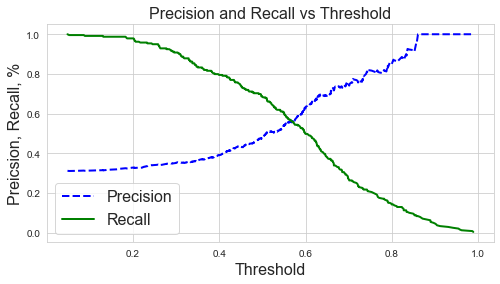

In [98]:
y_scores = clf_cl.predict_proba(X_train_prepared_cl)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_cl['Sale_CL'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [99]:
y_pred_cl_tr = clf_cl.predict_proba(X_train_prepared_cl)
tresh = 0.8
pred_2 = []

for x in y_pred_cl_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_cl, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.72      0.99      0.83       534
           1       0.87      0.14      0.24       239

    accuracy                           0.73       773
   macro avg       0.80      0.57      0.54       773
weighted avg       0.77      0.73      0.65       773

39


In [100]:
%%time

#scale_pos_weight = total_negative_examples / total_positive_examples
wt_xgb_cl = len(y_train[y_train['Sale_CL'] == 0])/sum(y_train['Sale_CL'])

xgb_clf_cl = xgb.XGBClassifier(
    max_depth=10,
    learning_rate=0.00001,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=18,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.9,
    colsample_bytree=0.9,
    colsample_bylevel=0.9,
    colsample_bynode=0.9,
    reg_alpha=0.1,
    reg_lambda=0.1,
    scale_pos_weight=wt_xgb_cc,
    base_score=0.5,
    random_state=0,
    seed=42,
    missing=None
)

xgb_dmat = xgb.DMatrix(X_train_prepared_cl, label=y_train_cl)


xgb_clf_cl.fit(X_train_prepared_cl, y_train_cl['Sale_CL'].values)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_clf_cl.score(X_train_prepared_cl, y_train_cl)))

y_pred_cl = sklearn.model_selection.cross_val_predict(xgb_clf_cl, X=X_train_prepared_cl, y=y_train_cl['Sale_CL'].values, cv=5)

print(classification_report(y_train_cl, y_pred_cl))
print(sklearn.metrics.roc_auc_score(y_train_cl, y_pred_cl))

y_pred_cl.sum() / len(y_pred_cl)

Accuracy of XGB classifier on training set: 0.75
              precision    recall  f1-score   support

           0       0.78      0.55      0.65       534
           1       0.40      0.65      0.49       239

    accuracy                           0.58       773
   macro avg       0.59      0.60      0.57       773
weighted avg       0.66      0.58      0.60       773

0.6035133906884178
Wall time: 2.65 s


0.5097024579560155

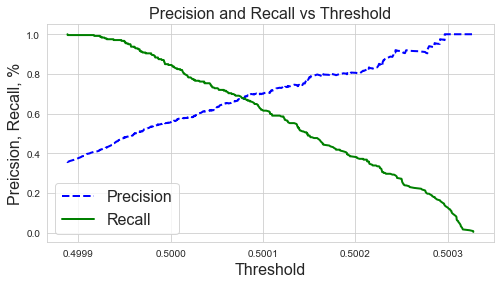

In [101]:
y_scores = xgb_clf_cl.predict_proba(X_train_prepared_cl)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_cl['Sale_CL'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [102]:
y_pred_cl_tr = xgb_clf_cl.predict_proba(X_train_prepared_cl)
tresh = 0.50027
pred_2 = []

for x in y_pred_cl_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_train_cl, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.74      0.99      0.85       534
           1       0.91      0.22      0.36       239

    accuracy                           0.75       773
   macro avg       0.83      0.61      0.60       773
weighted avg       0.79      0.75      0.70       773

58


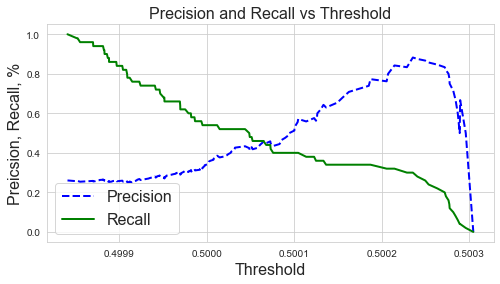

In [103]:
y_scores = xgb_clf_cl.predict_proba(X_test_prepared_cl)

y_scores = y_scores[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test_cl['Sale_CL'].values, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                             
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                      
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [104]:
#CL model hold up much better than the others on test data, maintaining most accuracy

y_pred_cl_tr = xgb_clf_cl.predict_proba(X_test_prepared_cl)
tresh = 0.500242
pred_2 = []

for x in y_pred_cl_tr:
    if x[1] >= tresh:
        pred_2.append(1)
    else:
        pred_2.append(0)
        
print(classification_report(y_test_cl, pred_2))
print(sum(pred_2))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       144
           1       0.87      0.26      0.40        50

    accuracy                           0.80       194
   macro avg       0.83      0.62      0.64       194
weighted avg       0.81      0.80      0.76       194

15


# Prediction 

Let's apply the models we created to the data which does not have a response

In [105]:
full

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
909,M,21,27,1,nan,nan,1.00,nan,1.00,4.71,...,7.00,1.00,0.00,4.00,nan,nan,nan,nan,nan,nan
1217,M,38,165,1,nan,nan,nan,nan,nan,"6,752.24",...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
850,F,49,44,1,nan,nan,nan,nan,nan,43.52,...,6.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.89,0.00
1473,M,54,34,1,1.00,nan,nan,1.00,1.00,29.02,...,38.00,1.00,26.00,11.00,1.00,0.00,0.00,4.93,0.00,0.00
1038,M,29,106,1,nan,nan,nan,nan,nan,27.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,M,31,91,1,nan,nan,1.00,nan,nan,348.40,...,12.00,1.00,1.00,9.00,nan,nan,nan,nan,nan,nan
384,M,23,160,1,nan,nan,nan,nan,nan,"2,418.88",...,8.00,2.00,5.00,1.00,0.00,1.00,1.00,0.00,6.11,12.51
977,M,46,59,1,nan,nan,nan,nan,nan,"2,639.31",...,4.00,2.00,1.00,1.00,1.00,0.00,0.00,1.43,0.00,0.00


In [107]:
pred_df = pd.DataFrame(data=None, index=prediction_df_sale.index)
pred_df['Sale_MF_pred'] = xgb_clf_mf.predict_proba(prediction_df_sale)[:,1]
pred_df['Sale_CC_pred'] = xgb_clf_cc.predict_proba(prediction_df_sale)[:,1]
pred_df['Sale_CL_pred'] = xgb_clf_cl.predict_proba(prediction_df_sale)[:,1]

tresh_mf = 0.50017
tresh_cc = 0.500277
tresh_cl = 0.500242

In [108]:
clf_mf.classes_

array([0, 1], dtype=int64)

In [109]:
pd.options.display.float_format = '{:,.5f}'.format

In [110]:
print('Number of MF potential customers with high propensity: {} '.format(len(pred_df[pred_df['Sale_MF_pred'] >= tresh_mf])))
print('Number of CC potential customers with high propensity: {} '.format(len(pred_df[pred_df['Sale_CC_pred'] >= tresh_cc])))
print('Number of CL potential customers with high propensity: {} '.format(len(pred_df[pred_df['Sale_CL_pred'] >= tresh_cl])))

Number of MF potential customers with high propensity: 35 
Number of CC potential customers with high propensity: 38 
Number of CL potential customers with high propensity: 45 


In [111]:
pred_df['Sale_CL_pred'].max()

0.5003220438957214

In [112]:
preds_df = full[full['Sale_MF'].isnull()==True].drop(columns=['Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Sale_MF', 'Sale_CC', 'Sale_CL'])
preds_df = preds_df.merge(pred_df, how='left', left_index=True, right_index=True)

In [113]:
#let's create Z-scores with the prediction variables to make them easier to understand

preds_df['Sale_MF_pred_Z'] = ((preds_df['Sale_MF_pred'] - preds_df['Sale_MF_pred'].min()) / 
                                        (preds_df['Sale_MF_pred'].max() - preds_df['Sale_MF_pred'].min()))
preds_df['Sale_CC_pred_Z'] = ((preds_df['Sale_CC_pred'] - preds_df['Sale_CC_pred'].min()) / 
                                        (preds_df['Sale_CC_pred'].max() - preds_df['Sale_CC_pred'].min()))
preds_df['Sale_CL_pred_Z'] = ((preds_df['Sale_CL_pred'] - preds_df['Sale_CL_pred'].min()) / 
                                        (preds_df['Sale_CL_pred'].max() - preds_df['Sale_CL_pred'].min()))

## Estimating revenues

The most obvious option to estimate revenues is to perform a regression analysis. Unfortunately, even by running an exstensive grid search, the model is not effective.
A backup option, though less precise than a working regression, is to use the mean value of each product. 

In [114]:
%%time
##coarse grid search example for preliminary hyperparameter tuning [with param_comb = 1500]

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import StratifiedKFold
from scipy import stats



# A parameter grid for XGBoost

param_dist = {'n_estimators':[5, 10, 20, 50, 100, 150, 200, 250, 500, 1000, 1500],
              'booster': ['gbtree', 'gblinear', 'dart'],
              'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1],
              'subsample': stats.uniform(0.8, 0.1),
              'max_depth': stats.randint(1, 20),
              'colsample_bytree':stats.uniform(0.8, 0.1),
              'colsample_bylevel':stats.uniform(0.8, 0.1),
              'colsample_bynode':stats.uniform(0.8, 0.1),
              'min_child_weight': stats.randint(1, 5),
              'gamma':stats.randint(0, 10),
              'reg_alpha':stats.randint(0, 10),
              'reg_lambda':stats.randint(0, 10),
              'importance_type': ["weight", "cover", "total_gain", "total_cover"],
             }

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', silent=False, nthread=None, n_jobs=4, random_state=42)

folds = 5
param_comb = 5


random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=param_comb, n_jobs=4, cv=folds, 
                                   verbose=3, random_state=42, return_train_score=True, scoring = 'explained_variance', iid=False)

random_search.fit(X_train_prepared_mf, y_train['Revenue_MF'].values)

best_grid = random_search.best_estimator_

best_grid.fit(X_train_prepared_mf, y_train['Revenue_MF'].values)
y_pred_mf = sklearn.model_selection.cross_val_predict(best_grid, X=X_train_prepared_mf, y=y_train['Revenue_MF'].values, cv=5)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.8min finished


Wall time: 1min 48s


In [115]:
best_grid

XGBRegressor(base_score=0.5, booster='gblinear',
             colsample_bylevel=0.8948885537253334,
             colsample_bynode=0.896563203307456,
             colsample_bytree=0.8808397348116461, gamma=8,
             importance_type='cover', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=4, missing=None, n_estimators=200,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=7, reg_lambda=2, scale_pos_weight=1,
             seed=None, silent=False, subsample=0.8909320402078782,
             verbosity=1)

In [116]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score


best_grid_tweak = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.8772410999627285,
             colsample_bynode=0.8761275456350412,
             colsample_bytree=0.8955242768287344, gamma=7,
             importance_type='total_cover', learning_rate=0.01,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=20, n_jobs=4, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=4,
             reg_lambda=3, scale_pos_weight=1, seed=None, silent=False,
             subsample=0.8253642474341376, verbosity=1)


best_grid_tweak.fit(X_train_prepared_mf, y_train['Revenue_MF'].values)
y_pred_mf = sklearn.model_selection.cross_val_predict(best_grid_tweak, X=X_train_prepared_mf, y=y_train['Revenue_MF'].values, cv=5)

print(explained_variance_score(y_train['Revenue_MF'].values, y_pred_mf))
print(mean_absolute_error(y_train['Revenue_MF'].values, y_pred_mf))
print(mean_squared_error(y_train['Revenue_MF'].values, y_pred_mf))
print(max_error(y_train['Revenue_MF'].values, y_pred_mf))
print(r2_score(y_train['Revenue_MF'].values, y_pred_mf))

-0.0005675385904835295
2.033887104178903
47.71454168483261
82.42972084249769
-0.024075004452933646


In [117]:
best_grid_tweak_mf = best_grid_tweak
best_grid_tweak_mf.fit(X_test_prepared_mf, y_test['Revenue_MF'].values)
y_pred_mf = best_grid_tweak_mf.predict(X_test_prepared_mf)

print(explained_variance_score(y_test['Revenue_MF'].values, y_pred_mf))
print(mean_absolute_error(y_test['Revenue_MF'].values, y_pred_mf))
print(mean_squared_error(y_test['Revenue_MF'].values, y_pred_mf))
print(max_error(y_test['Revenue_MF'].values, y_pred_mf))
print(r2_score(y_test['Revenue_MF'].values, y_pred_mf))

0.07669283503112745
3.1856122686339763
288.14928100035416
212.0398795918056
0.05919500621949836


In [118]:
best_grid_tweak_cc = best_grid_tweak
best_grid_tweak_cc.fit(X_test_prepared_cc, y_test['Revenue_CC'].values)
y_pred_cc = best_grid_tweak_cc.predict(X_test_prepared_cc)

print(explained_variance_score(y_test['Revenue_CC'].values, y_pred_cc))
print(mean_absolute_error(y_test['Revenue_CC'].values, y_pred_cc))
print(mean_squared_error(y_test['Revenue_CC'].values, y_pred_cc))
print(max_error(y_test['Revenue_CC'].values, y_pred_cc))
print(r2_score(y_test['Revenue_CC'].values, y_pred_cc))

0.07513043919039286
3.463872110843659
420.84368004408697
204.6007795061384
0.05975151725192607


In [119]:
best_grid_tweak_cl = best_grid_tweak
best_grid_tweak_cl.fit(X_test_prepared_cl, y_test['Revenue_CL'].values)
y_pred_cl = best_grid_tweak_cl.predict(X_test_prepared_cl)

print(explained_variance_score(y_test['Revenue_CL'].values, y_pred_cl))
print(mean_absolute_error(y_test['Revenue_CL'].values, y_pred_cl))
print(mean_squared_error(y_test['Revenue_CL'].values, y_pred_cl))
print(max_error(y_test['Revenue_CL'].values, y_pred_cl))
print(r2_score(y_test['Revenue_CL'].values, y_pred_cl))

0.13637762165482903
2.9390281624883543
40.111970249998
43.729301759174895
0.024511280661801305


In [128]:
#let's take a deep look at predictions - the regression is not performing at all
pred_mf_df = pd.DataFrame(data=y_pred_mf, index=y_test.index, columns=['Revenue_MF_pred'])
check_mf = y_test[['Revenue_MF']].merge(pred_mf_df, left_index=True, right_index=True, how='inner')
check_mf['diff'] = check_mf['Revenue_MF'] - check_mf['Revenue_MF_pred']
check_mf[check_mf['Revenue_MF'] > 0].sort_values(by='diff', ascending=False)

,Revenue_MF,Revenue_MF_pred,diff
Client,,,
27,220.48821,8.44833,212.03988
349,65.70411,2.65012,63.05399
310,56.13982,3.24052,52.89930
1502,34.01661,2.76901,31.24760
864,30.69732,2.63366,28.06366
129,28.29554,2.65117,25.64436
1,26.97268,2.71365,24.25903
1469,22.74250,2.08341,20.65909
1206,22.16589,2.52626,19.63964


In [129]:
#let's create prediction variables using the mean
#we use the mean computer for purchasing customers because we are asking the question "given that they purchase, how much revenues will they generate"
#then, to make it closer to an expected value, we multiply the mean by the precision of each model at the threshold used

mean_mf = response[response['Revenue_MF'] > 0]['Revenue_MF'].mean()
mean_cc = response[response['Revenue_CC'] > 0]['Revenue_CC'].mean()
mean_cl = response[response['Revenue_CL'] > 0]['Revenue_CL'].mean()

prediction_df_sale['Revenue_MF_pred'] = mean_mf
prediction_df_sale['Revenue_CC_pred'] = mean_cc
prediction_df_sale['Revenue_CL_pred'] = mean_cl

full_pred_df = preds_df.merge(prediction_df_sale[['Revenue_MF_pred', 'Revenue_CC_pred', 'Revenue_CL_pred']], how='inner', left_index=True, right_index=True)

precision_mf = 0.70
precision_cc = 0.73
precision_cl = 0.87

full_pred_df['Revenue_MF_pred'] = full_pred_df['Revenue_MF_pred'] * precision_mf
full_pred_df['Revenue_CC_pred'] = full_pred_df['Revenue_CC_pred'] * precision_cc
full_pred_df['Revenue_CL_pred'] = full_pred_df['Revenue_CL_pred'] * precision_cl

# Scoring of predictions

Given that we have capacity to target 100 customers, we need to define a strategy to prioritize potential customers.

Assuming we want to promote all the products to a certain extent, given that
1) the classifier for CL is much more precise than the others (87% precision on threshold vs 70% and 73% for MF and CL respectively), and

2) CL is the most profitable products

Then, CL should be prioritized over the others. For the same reasons, since the model for CC is performing better than that for MF, and CC is more profitable, CC should also be prioritized after CL.

CC + CL predictions above threshold amount to: 37 + 45, respectively, thus 83 (considering 1 flagged on both, where CL takes precedence)
For the remaining 19 "spots", these can be assigned to MF customers > treshold, prioritizing by a usage metric such as TransactionsCred_CA, which is also fairly correlated (at least compared to others) to the response.

In [130]:
#flag customers
full_pred_df['flag'] = 0
full_pred_df.loc[full_pred_df['Sale_CL_pred'] > tresh_cl, 'flag'] = 'CL'
full_pred_df.loc[(full_pred_df['Sale_CC_pred'] > tresh_cc) & (full_pred_df['flag'] != 'CL'), 'flag'] = 'CC'
rest_mf = full_pred_df[(full_pred_df['Sale_MF_pred'] > tresh_mf) & (full_pred_df['flag'] != 'CL') & 
             (full_pred_df['flag'] != 'CC')].sort_values(by='TransactionsCred_CA', ascending=False).head(18).index
full_pred_df.loc[full_pred_df.index.isin(rest_mf), 'flag'] = 'MF'
cl_flag = full_pred_df['flag'].value_counts().iloc[1]
cc_flag = full_pred_df['flag'].value_counts().iloc[2]
mf_flag = full_pred_df['flag'].value_counts().iloc[3]
print('Total targeted customers: {}'.format(cl_flag + cc_flag + mf_flag))

Total targeted customers: 100


In [153]:
full_pred_df['flag'].value_counts()

0     545
CL     45
CC     37
MF     18
Name: flag, dtype: int64

In [131]:
#expected revenue
rev_pred_mf = full_pred_df[full_pred_df['flag'] == 'MF']['Revenue_MF_pred'].sum()
rev_pred_cc = full_pred_df[full_pred_df['flag'] == 'CC']['Revenue_CC_pred'].sum()
rev_pred_cl = full_pred_df[full_pred_df['flag'] == 'CL']['Revenue_CL_pred'].sum()

print('Total expected revenues: {}'.format(rev_pred_mf + rev_pred_cc + rev_pred_cl))

Total expected revenues: 886.6612906205842


### Let's compare some basic statistics for the targeted customers



In [143]:
full_pred_df['Tenure'].mean()

102.90697674418605

125.44444444444444


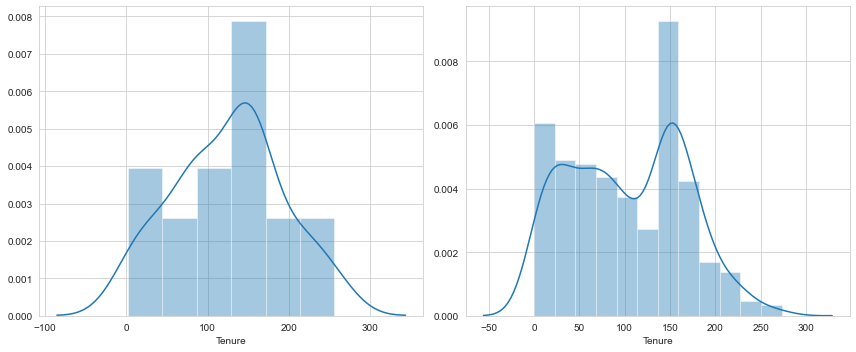

In [151]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'MF']['Tenure'], ax=axes[0])
sns.distplot(full_pred_df['Tenure'], ax=axes[1])
f.tight_layout()
print(full_pred_df[full_pred_df['flag'] == 'MF']['Tenure'].mean())

98.16216216216216


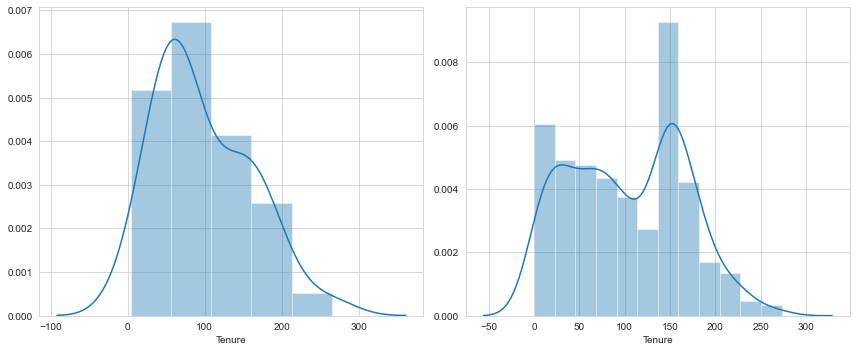

In [149]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'CC']['Tenure'], ax=axes[0])
sns.distplot(full_pred_df['Tenure'], ax=axes[1])
f.tight_layout()
print(full_pred_df[full_pred_df['flag'] == 'CC']['Tenure'].mean())

177.44444444444446


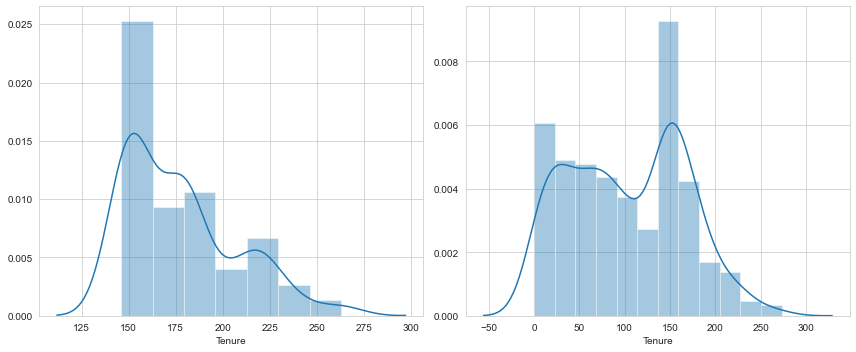

In [152]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'CL']['Tenure'], ax=axes[0])
sns.distplot(full_pred_df['Tenure'], ax=axes[1])
f.tight_layout()
print(full_pred_df[full_pred_df['flag'] == 'CL']['Tenure'].mean())

2350.4895382059804
896.5008333333333


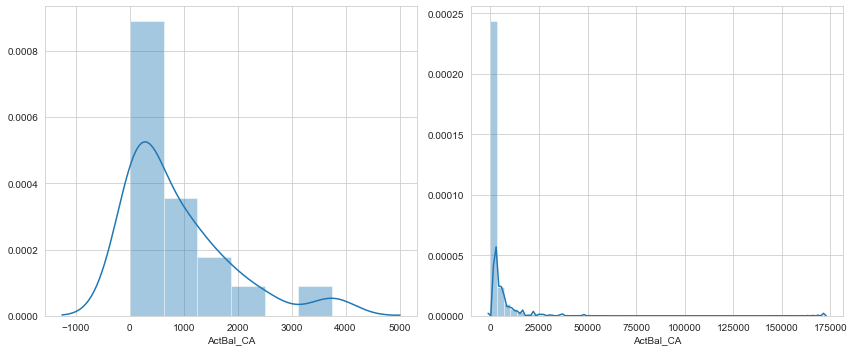

In [161]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'MF']['ActBal_CA'], ax=axes[0])
sns.distplot(full_pred_df['ActBal_CA'], ax=axes[1])
f.tight_layout()
print(full_pred_df['ActBal_CA'].mean())
print(full_pred_df[full_pred_df['flag'] == 'MF']['ActBal_CA'].mean())

2350.4895382059804
14007.62416023166


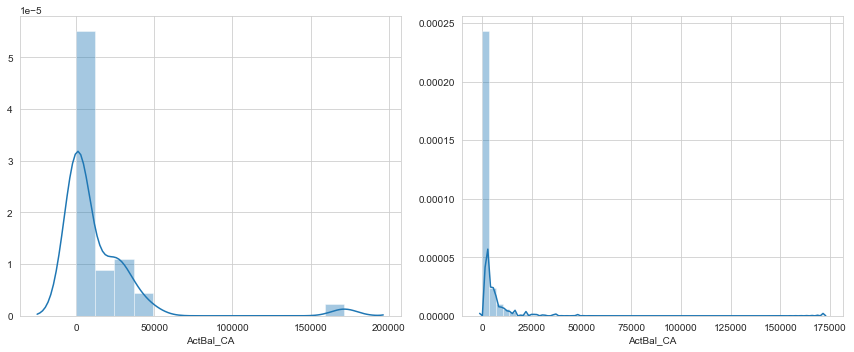

In [159]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'CC']['ActBal_CA'], ax=axes[0])
sns.distplot(full_pred_df['ActBal_CA'], ax=axes[1])
f.tight_layout()
print(full_pred_df['ActBal_CA'].mean())
print(full_pred_df[full_pred_df['flag'] == 'CC']['ActBal_CA'].mean())

2350.4895382059804
3259.6601746031743


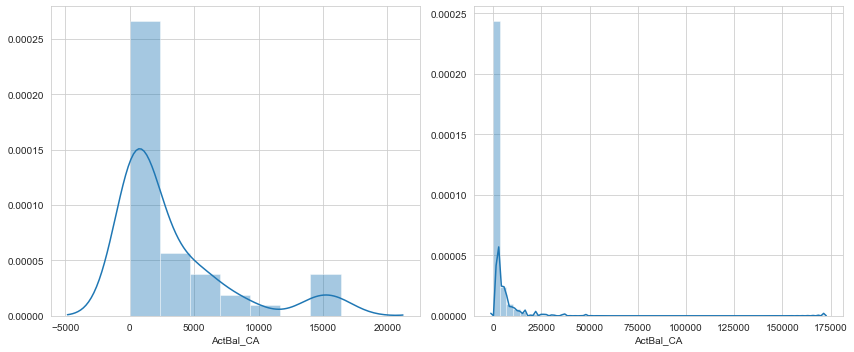

In [160]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'CL']['ActBal_CA'], ax=axes[0])
sns.distplot(full_pred_df['ActBal_CA'], ax=axes[1])
f.tight_layout()
print(full_pred_df['ActBal_CA'].mean())
print(full_pred_df[full_pred_df['flag'] == 'CL']['ActBal_CA'].mean())

1688.8049651293597
8937.217301587305


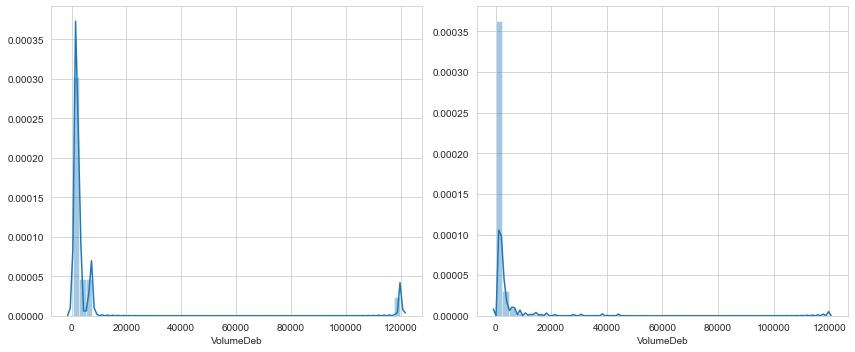

In [176]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(full_pred_df[full_pred_df['flag'] == 'MF']['VolumeDeb'], ax=axes[0])
sns.distplot(full_pred_df[full_pred_df['VolumeDeb'].isnull()==False]['VolumeDeb'], ax=axes[1])
f.tight_layout()
print(full_pred_df['VolumeDeb'].mean())
print(full_pred_df[full_pred_df['flag'] == 'MF']['VolumeDeb'].mean())

In [179]:
#flagged data points
full_pred_df[full_pred_df['flag'] != 0]

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,Sale_MF_pred,Sale_CC_pred,Sale_CL_pred,Sale_MF_pred_Z,Sale_CC_pred_Z,Sale_CL_pred_Z,Revenue_MF_pred,Revenue_CC_pred,Revenue_CL_pred,flag
Client,,,,,,,,,,,,,,,,,,,,,
109,M,64,151,1,nan,nan,nan,nan,nan,"1,113.51857",...,0.50023,0.50014,0.49989,0.91538,0.57985,0.14149,6.76548,7.92964,10.47747,MF
668,F,55,119,1,1.00000,1.00000,1.00000,nan,nan,586.94929,...,0.50021,0.50029,0.50006,0.87979,0.88526,0.47974,6.76548,7.92964,10.47747,CC
1076,F,22,61,1,1.00000,nan,nan,nan,nan,142.85714,...,0.49986,0.50031,0.49992,0.30389,0.93063,0.21262,6.76548,7.92964,10.47747,CC
1063,M,5,230,1,nan,nan,1.00000,nan,1.00000,291.14750,...,0.49979,0.49993,0.50026,0.17913,0.14770,0.88018,6.76548,7.92964,10.47747,CL
19,F,46,94,1,1.00000,nan,nan,nan,nan,"26,118.09857",...,0.49985,0.50034,0.49988,0.28021,1.00000,0.13538,6.76548,7.92964,10.47747,CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,M,39,151,1,1.00000,nan,nan,nan,nan,9.63643,...,0.49988,0.50030,0.50018,0.33375,0.92297,0.71291,6.76548,7.92964,10.47747,CC
731,F,21,181,1,nan,nan,nan,nan,nan,957.00714,...,0.49978,0.49989,0.50029,0.16302,0.06887,0.93187,6.76548,7.92964,10.47747,CL
1491,M,19,151,1,nan,nan,1.00000,nan,nan,"15,886.91179",...,0.49992,0.50004,0.50025,0.40389,0.36556,0.86092,6.76548,7.92964,10.47747,CL


In [181]:
#export predictions
full_pred_df[full_pred_df['flag'] != 0].to_excel(os.path.join(output,r'task_ds_pr_output.xlsx'))